# 데이터 불러오기

In [2]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 경고 무시
warnings.filterwarnings('ignore')

#한글 처리를 위해 폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [3]:
df = pd.read_csv('../csv/preprocess.csv')
df.head()

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_24h,date_of_birth_distinct_emails_4w,...,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.9,0.642713,0.0,20,0.009624,105.898067,1724,7394.902554,8,...,1,0,0,1,0,0,0,1,0,0
1,0,0.9,0.720064,200.0,40,0.007018,33.006203,1986,5416.601990,5,...,1,0,0,1,0,0,0,0,1,0
2,0,0.9,0.075432,129.0,40,0.009764,-0.632448,2411,7423.819019,7,...,0,0,0,1,0,0,0,0,1,0
3,0,0.5,0.784344,240.0,20,0.017281,-1.612753,1731,4489.610329,8,...,1,0,0,1,0,1,0,0,0,0
4,0,0.8,0.770435,150.0,40,9.370346,26.733867,1863,6301.097061,7,...,0,0,0,1,0,1,0,0,0,0


# 분석

In [4]:
train_cols = df.columns[1:]
X = df[train_cols] # 독립변수
y = df["fraud_bool"] # 종속변수
df["fraud_bool"].value_counts()

0    6871
1    6871
Name: fraud_bool, dtype: int64

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [6]:
pipe = Pipeline([
('scaler', StandardScaler()),
('clf', SVC(random_state=0)),
])
params = {
'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
'clf__gamma': [0.0001, 0.001, 0.01, 0.1],
'clf__kernel': ['linear', 'sigmoid', 'rbf', 'poly'],
}
grid = GridSearchCV(pipe, params, scoring='accuracy', cv=3)
grid.fit(X, y)
print(grid.best_params_)
print(grid.best_score_)

# {'clf__C': 1000, 'clf__gamma': 0.0001}
# 0.7886769667892857

# {'clf__C': 1000, 'clf__gamma': 0.0001, 'clf__kernel': 'linear'}
# 0.789041042569667

{'clf__C': 1000, 'clf__gamma': 0.0001, 'clf__kernel': 'linear'}
0.7889682782532877


In [7]:
model = grid.best_estimator_['clf']
model.fit(X, y)

SVC(C=1000, gamma=0.0001, kernel='linear', random_state=0)

In [8]:
from sklearn.metrics import classification_report
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      6871
           1       0.80      0.78      0.79      6871

    accuracy                           0.79     13742
   macro avg       0.79      0.79      0.79     13742
weighted avg       0.79      0.79      0.79     13742



In [16]:
pred = grid.predict(X)

In [17]:
#confusion matrix(혼동행렬, 오분류표) 출력
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y, pred)
cm

array([[6474,  397],
       [3643, 3228]], dtype=int64)

In [18]:
df_cm=pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
df_cm

,0,1
0,6474,397
1,3643,3228


In [19]:
tpr = df_cm.loc[0,0] / (df_cm.loc[0,0] + df_cm.loc[1,0])
fpr = df_cm.loc[0,1] / (df_cm.loc[0,1] + df_cm.loc[1,1])
precision = df_cm.loc[0,0] / (df_cm.loc[0,0] + df_cm.loc[0,1])
recall = df_cm.loc[0,0] / (df_cm.loc[0,0] + df_cm.loc[1,0])
f = (2 * (precision * recall)) / (precision + recall)
print(tpr, fpr, precision, recall, f)

0.639913017692992 0.10951724137931035 0.9422209285402416 0.639913017692992 0.7621850718153991


# 시각화

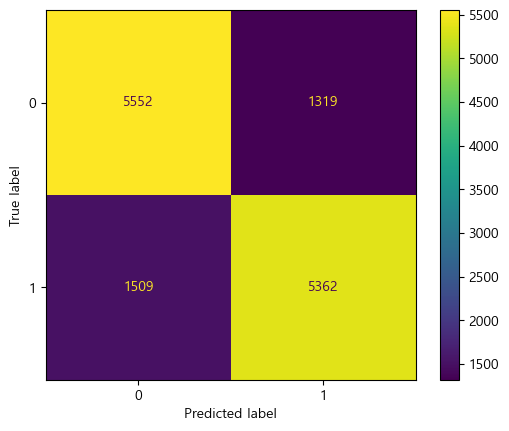

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y, model.predict(X))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

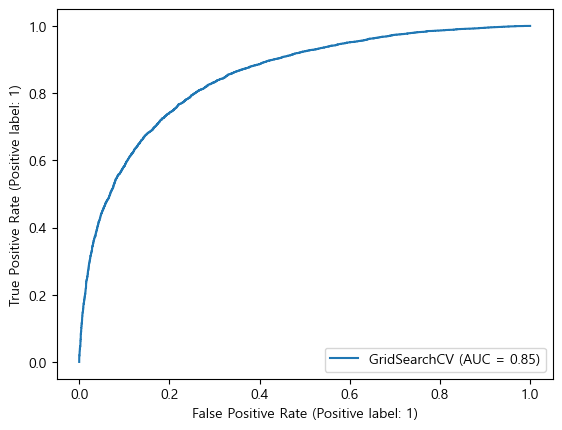

In [10]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(grid, X, y)

# 저장

In [21]:
result = pd.read_csv('../csv/model_results.csv')
result

,Model,Best Score,Best Parameter,Precision,Recall,F1-score,TPR,FPR,AUC
0,KNN,0.768374,"{'clf__n_neighbors': 20, 'clf__p': 2, 'clf__we...",0.814874,0.778071,0.796047,0.778071,0.194317,0.87
1,ANN,0.745668,"{'clf__activation': 'relu', 'clf__alpha': 0.1,...",0.851841,0.848753,0.850294,0.848753,0.148700,0.93
2,DNN,0.784456,"{'clf__batch_size': 128, 'clf__epochs': 50, 'c...",0.831757,0.817714,0.824675,0.817714,0.171183,0.90


In [23]:
if 'SVM' in result.Model.values.tolist():
    result.loc[result.Model.values.tolist().index('SVM')] = ['SVM', grid.best_score_, grid.best_params_, precision, recall, f, tpr, fpr, 0.87]
else:
    result.loc[len(result.index)] = ['SVM', grid.best_score_, grid.best_params_, precision, recall, f, tpr, fpr, 0.87]
result

,Model,Best Score,Best Parameter,Precision,Recall,F1-score,TPR,FPR,AUC
0,KNN,0.768374,"{'clf__n_neighbors': 20, 'clf__p': 2, 'clf__we...",0.814874,0.778071,0.796047,0.778071,0.194317,0.87
1,ANN,0.745668,"{'clf__activation': 'relu', 'clf__alpha': 0.1,...",0.851841,0.848753,0.850294,0.848753,0.148700,0.93
2,DNN,0.784456,"{'clf__batch_size': 128, 'clf__epochs': 50, 'c...",0.831757,0.817714,0.824675,0.817714,0.171183,0.90
3,SVM,0.788968,"{'clf__C': 1000, 'clf__gamma': 0.0001, 'clf__k...",0.942221,0.639913,0.762185,0.639913,0.109517,0.87


In [24]:
result.to_csv('../csv/model_results.csv', index=None)

In [25]:
import joblib
joblib.dump(model, '../model/svm.h5')

['../model/svm.h5']